In [80]:
import numpy as np
import pandas as pd
import folium
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt

In [81]:
moskva = pd.read_csv('clean_data_MSK.csv', sep=':')
moskva.head()

,lighting,lat,long,region,category,date,severity,dead,injured,n_participants,...,Пешеходы,Другое,Эксплуатация,Нарушения при движении,Нарушение правил подачи/приема сигналов,Не пострадал,Легкие травмы,Скончался после госпитализации,Ранения,Скончался до госпитализации
0,Светлое время суток,55.616777,37.706516,Орехово-Борисово Северное,Наезд на пешехода,2020-03-24 13:06:00,Легкий,0,1,2,...,0,0,0,0,0,0,0,0,1,0
1,Светлое время суток,55.841157,37.489332,Головинский,Столкновение,2018-09-15 11:00:00,Легкий,0,1,2,...,0,0,0,0,0,0,0,0,0,0
2,"В темное время суток, освещение включено",55.713332,37.658944,Даниловский,Наезд на пешехода,2016-04-14 21:25:00,Легкий,0,1,2,...,0,0,0,0,0,0,0,0,1,0
3,Светлое время суток,55.655243,37.414176,Солнцево,Столкновение,2019-06-20 18:15:00,Легкий,0,1,2,...,0,0,0,0,0,0,0,0,0,0
4,Светлое время суток,55.756493,37.789315,Перово,Наезд на пешехода,2016-04-04 11:50:00,Легкий,0,1,2,...,0,0,0,0,0,0,0,0,1,0


In [82]:
moskva_new = moskva

Display probability of death by category of accident.

In [123]:
categor_df = moskva_new[['category', 'dead', 'injured', 'n_participants']].groupby('category').sum()
categor_df["P_death"] = categor_df['dead'] / categor_df['n_participants']
categor_df['P_death'] /= categor_df['P_death'].sum()
categor_df.sort_values(by='P_death', ascending=False).round(2)

,dead,injured,n_participants,P_death
category,,,,
"Наезд на лицо, не являющееся участником дорожного движения, осуществляющее производство работ",22,45,121,0.23
Съезд с дороги,10,63,88,0.14
"Наезд на лицо, не являющееся участником дорожного движения, осуществляющее какую-либо другую деятельность",3,15,31,0.12
"Наезд на лицо, не являющееся участником дорожного движения, осуществляющее несение службы",5,29,67,0.09
Наезд на животное,1,9,14,0.09
Наезд на препятствие,366,3803,5374,0.09
Опрокидывание,32,615,782,0.05
Иной вид ДТП,4,57,103,0.05
Наезд на стоящее ТС,259,3478,7400,0.04


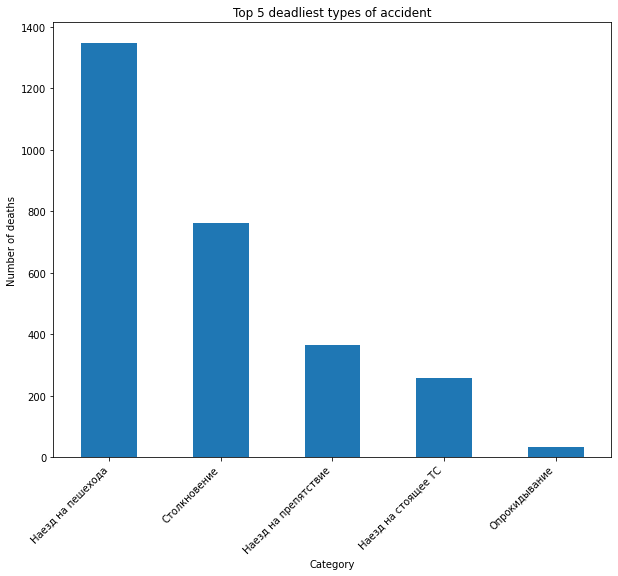

In [119]:
plt.figure(figsize=(10,8))
categor_df['dead'].sort_values(ascending=False)[:5].plot.bar()
plt.title("Top 5 deadliest types of accident")
plt.xticks(rotation=45, ha="right")
plt.xlabel("Category")
plt.ylabel("Number of deaths")
plt.savefig('imgs/pdf_files/top5deaths.pdf', bbox_inches='tight')
plt.show()

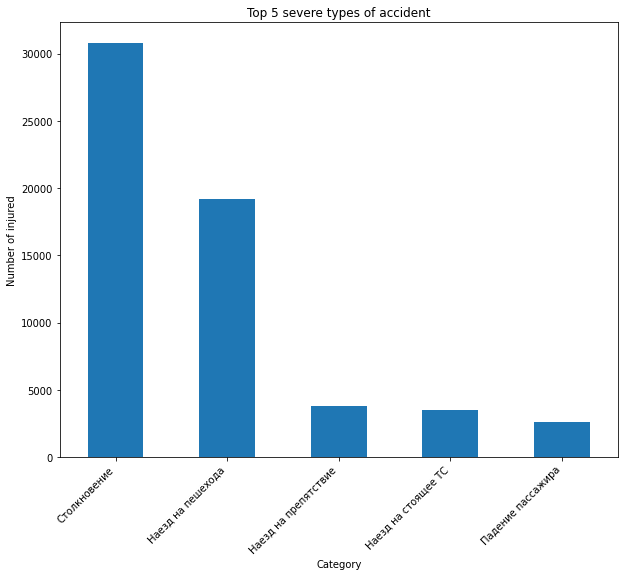

In [120]:
plt.figure(figsize=(10,8))
categor_df['injured'].sort_values(ascending=False)[:5].plot.bar()
plt.title("Top 5 severe types of accident")
plt.xticks(rotation=45, ha="right")
plt.xlabel("Category")
plt.ylabel("Number of injured")
plt.savefig('imgs/pdf_files/top5injuries.pdf', bbox_inches='tight')
plt.show()

Heavy map, which contains all accidents inside defined boundaries

In [102]:
map_ = folium.Map([55.75215, 37.61819], zoom_start=10)
for id, row in moskva_new.iterrows():
    folium.Circle([row['lat'], row['long']],
                  radius=10).add_to(map_)

The following functions are responsible for defining DBSCAN model and displaying problematic regions on folium map

In [104]:
def select_problematic_clusters(coordinates, distance: float, min_samples: int) -> DBSCAN:
    """
    ==========
    Parameters:
        coordinates: pd.Dataframe or np.array containing latitude and longitude
        distance: float, neighbourhood distance for DBSCAN;

        intuitively, this parameter helps us to define the most problematic regions with accidents, according to which
        neighbourhood distance between the accidents is at most 'distance' km

        min_samples: int, number of samples for accident to be considered as core point by DBSCAN
        
        intuitively, min_samples helps us regulate the density of problematic regions

    ==========
    Return:
        DBSCAN – fitted DBSCAN model
    """
    model = DBSCAN(eps=distance/6371., min_samples=min_samples, metric='haversine')
    model.fit(np.radians(coordinates))
    return model


def DBSCAN_clustered_map(data, cluster_model, zoom: int=11, dead: bool=True, hard: bool=True, light: bool=False):
   """
   Create map with problematic clusters, colour them depending on the severity

   ==========
   Parameters:
      data: pd.DataFrame - public transport stops data (coordinates + severity)
      cluster_model: DBSCAN model
      dead: bool, include lethal accidents
      hard: bool, include severe accidents
      light: bool, include non-severe accidents


   ==========
   Returns: 
      folium.Map - map with coloured clusters
   """
   labels = cluster_model.labels_
   df = data[['lat', 'long', 'severity']].copy()
   df.insert(2, "labels", labels + 1)

   Moscow_Map = folium.Map([55.75215, 37.61819], zoom_start=zoom)
   for id, row in df.iterrows():
      idx = row.labels - 1
      if idx >= 0:
         if row.severity=='С погибшими' and dead:
            folium.Circle([row.lat, row.long],
                  radius=40, color='red').add_to(Moscow_Map)
         elif row.severity=='Тяжёлый' and hard:
            folium.Circle([row.lat, row.long],
                  radius=26, color='purple').add_to(Moscow_Map)
         elif row.severity=='Легкий' and light:
            folium.Circle([row.lat, row.long],
                  radius=5, color='lightgreen').add_to(Moscow_Map)
   
   return Moscow_Map

In [105]:
prob_regions = DBSCAN_clustered_map(moskva_new, select_problematic_clusters(moskva_new[['lat', 'long']].values, 0.1, 15), zoom=12.5)

In [106]:
from utils.save_map import save_map_html_and_png

Example of problem region, zoomed:

In [107]:
save_map_html_and_png(prob_regions, 'msc_problem_regions')